In [4]:
from pathlib import Path
from typing import Dict, Tuple
import pandas as pd
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm.notebook import tqdm
import csv
from datetime import datetime
from typing import Iterable, List
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.axis import Axis
from matplotlib.figure import Figure
from matplotlib.ticker import AutoMinorLocator

logs_dir = Path("../lightning_logs/theo_cov_0214")
results_dir = Path(f"results_0214/")

# Save result

In [5]:
results_dir.mkdir(parents=True, exist_ok=True)

total_df = pd.DataFrame()
seeds = sorted([entry for entry in logs_dir.iterdir() if entry.is_dir()])

for seed in tqdm(seeds, desc='seed', leave=False):
    seed_name = seed.name
    models = sorted(list(seed.iterdir()))
    # try :
    for model in models:
        if Path(results_dir/Path(f"{seed_name}_{model.name}.csv")).exists():
            continue
        key = (seed_name, model.name)
        version = sorted([entry for entry in model.iterdir() if entry.is_dir()])[-1]
        event = sorted(list(version.glob('event*')))[-1]
        event_acc = EventAccumulator(str(event))
        event_acc.Reload()
        parameter_names : List[str]= event_acc.Tags()['scalars']
        parameter_names.remove('val_loss')
        dataset : Dict[str, any]= {}
        for para_name in parameter_names :
            records = event_acc.Scalars(para_name)
            records_len = len(records)
            if records_len < 2 :
                continue
            step = int(records_len/100)
            if step > 0 :
                records = records[:-1:step] + [records[-1]]
            else :
                pass
            if not 'step' in dataset.keys():
                dataset['step'] = [r.step for r in records]
            dataset[para_name] = [r.value for r in records]
        
        event_acc = pd.DataFrame(dataset)
        event_acc.to_csv(results_dir/Path(f"{seed_name}_{model.name}.csv"), index=False)
    # except :
    #     print(key)

seed:   0%|          | 0/50 [00:00<?, ?it/s]

# plot result

In [6]:
def get_model_parameter(
        csv_path : Path, 
        para_names : Iterable[str],
    ) -> Dict[str, float] :
    var_dict : Dict[str, float] = {}
    df = pd.read_csv(csv_path)
    for para_name in para_names:
        y = df[para_name]  # X-axis data
        var_dict[para_name] = y.iloc[-1]
    return var_dict

def stack_model_parameter(
        csv_paths: Iterable[Path],
        para_names: Iterable[str],
    ) -> Dict[str, List[float]] :
    list_dict : Dict[str, List[float]] = {}
    for csv_path in csv_paths:
        para_dict = get_model_parameter(
            csv_path=csv_path,
            para_names=para_names
        )
        for name, value in para_dict.items():
            value_list = list_dict.get(name, [])
            value_list.append(value)
            list_dict[name] = value_list
    return list_dict

def collect_models(
        csv_paths_list: Iterable[Iterable[Path]],
        model_names : Iterable[str] = ['total','base', '1_2_3', '1_2', '1_3', '2_3', '1', '2', '3'],
        para_names: Iterable[str] = ['train_loss', 'v','k_a', 'k_e', 'omega_v', 'omega_k_a', 'omega_k_e', 'error',],
) -> Dict[Tuple[str,str],List[float]] :
    parameter_name = str
    model_name = str
    para_model_dict : Dict[parameter_name,Dict[model_name,List(float)]] = {}
    for model_name, csv_paths in zip(model_names, csv_paths_list):
        para_list_dict = stack_model_parameter(
            csv_paths=csv_paths,
            para_names=para_names)
        for para_name, para_list in para_list_dict.items():
            model_dict = para_model_dict.get(para_name, {})
            model_dict[model_name] = para_list
            para_model_dict[para_name] = model_dict
    return para_model_dict
    
from matplotlib import rcParams
total_path_list = results_dir.glob('*.csv')
base_path_list = results_dir.glob('*base_model.csv')
cov_1_2_3_path_list = results_dir.glob('*cov_1_2_3_model.csv')
cov_1_2_path_list = results_dir.glob('*cov_1_2_model.csv')
cov_1_3_path_list = results_dir.glob('*cov_1_3_model.csv')
cov_2_3_path_list = results_dir.glob('*cov_2_3_model.csv')
cov_1_list = results_dir.glob('*cov_1_model.csv')
cov_2_list = results_dir.glob('*cov_2_model.csv')
cov_3_list = results_dir.glob('*cov_3_model.csv')
model_path_list = [total_path_list, base_path_list, cov_1_2_3_path_list, cov_1_2_path_list, cov_1_3_path_list, cov_2_3_path_list, cov_1_list, cov_2_list, cov_3_list]
para_names =  ['train_loss', 'v','k_a', 'k_e', 'omega_v', 'omega_k_a', 'omega_k_e', 'sigma',]
model_names = ['total','base', 'cov_1_2_3', 'cov_1_2', 'cov_1_3', 'cov_2_3', 'cov_1', 'cov_2', 'cov_3']


dataset = collect_models(
    csv_paths_list=model_path_list,
    model_names=model_names,
    para_names=para_names)



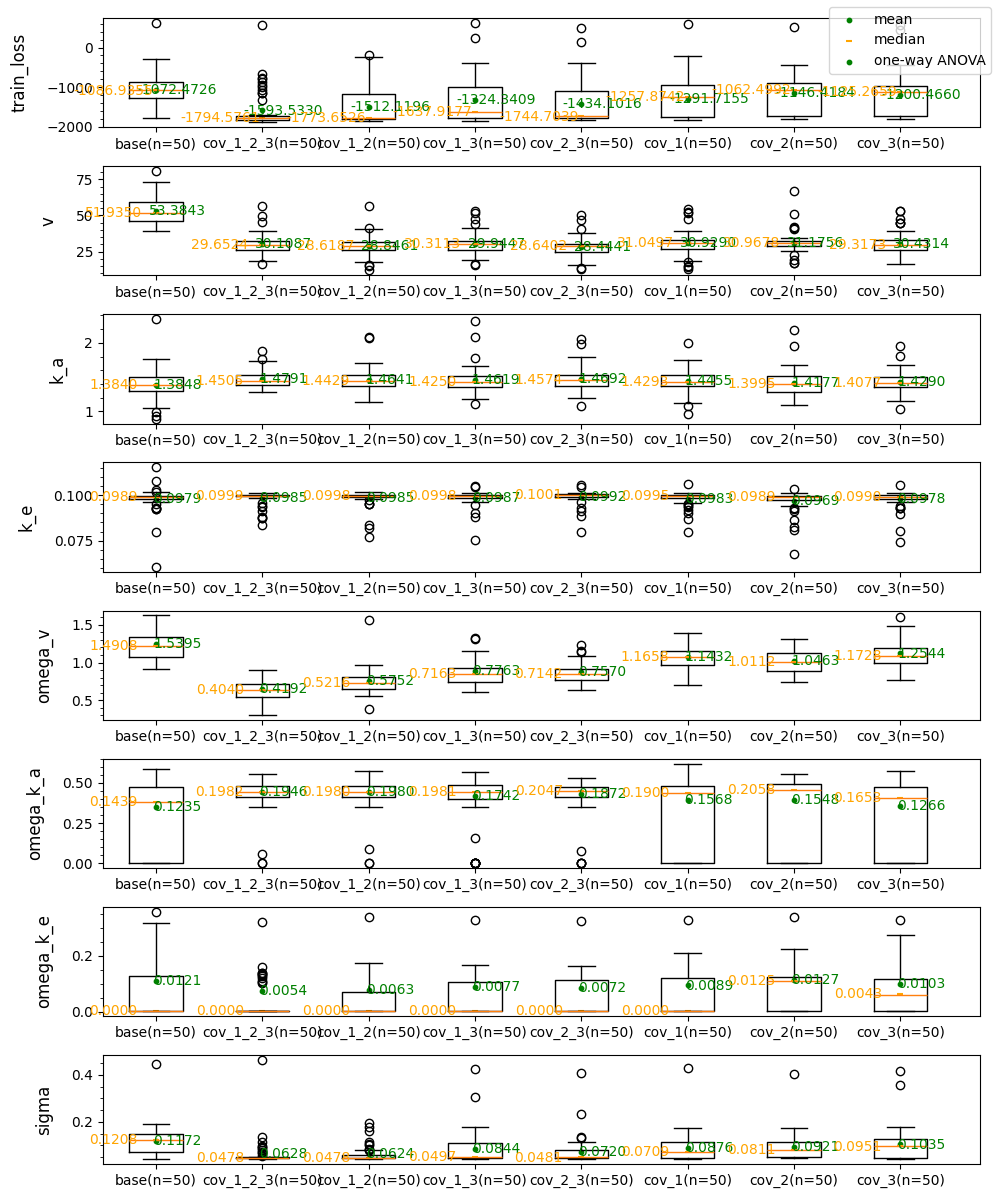

In [7]:
from scipy.stats import f_oneway
fig, axs  = plt.subplots(8, 1, figsize=(10,12))
model_names = ['base', 'cov_1_2_3', 'cov_1_2', 'cov_1_3', 'cov_2_3', 'cov_1', 'cov_2', 'cov_3']
axs : List[Axes]= axs.flatten()
for i, para_name in enumerate(para_names) :
    values = []
    for model_i, model_name in enumerate(model_names) :
        value = dataset[para_name][model_name]
        values.append(value)
        mean = np.mean(np.array(value))
        median = np.median(np.array(value))
        
        if para_name.startswith('omega'):
            axs[i].scatter(model_i+1, np.sqrt(mean), color='g', label='Mean', s=10)
            axs[i].scatter(model_i+1, np.sqrt(median), color='orange', label='median', s=20, marker = '_')

            axs[i].text(model_i+1.2, np.sqrt(mean), f'{mean:.4f}', va='center', ha='center', color='g')
            axs[i].text(model_i+0.6, np.sqrt(median), f'{median:.4f}', va='center', ha='center', color='orange')
        else :
            axs[i].scatter(model_i+1, mean, color='g', label='Mean', s=10)
            axs[i].scatter(model_i+1, median, color='orange', label='median', s=20, marker = '_')

            axs[i].text(model_i+1.2, mean, f'{mean:.4f}', va='center', ha='center', color='g')
            axs[i].text(model_i+0.6, median, f'{median:.4f}', va='center', ha='center', color='orange')

    # anova_test = f_oneway(*values)
    # axs[i].text(len(model_names)+1, np.array(values).mean(), f'p-value:{anova_test.pvalue:.4f}', va='center', ha='center', color='r', label='one-way ANOVA')


    if para_name.startswith('omega'):
        # values=np.clip(values, 1e-3, 10000)
        axs[i].boxplot(list(np.sqrt(values)))#, showmeans=True)
    else :
        axs[i].boxplot(values)#, showmeans=True)
    axs[i].set_xticklabels([f'{name}(n={len(value)})' for name, value in zip(model_names, values)])
    # axs[i].set_xlim(0.5,9.75)
    axs[i].set_xlim(0.5,8.75)
    
    # hs, _ = axs[i].get_legend_handles_labels()
    # hs[8].set_color('r')


for ax, row in zip(axs, para_names):
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
rcParams['font.size']=10
fig.legend(['mean', 'median', 'one-way ANOVA'], loc='upper right')
fig.tight_layout()


# VPC

seed:   0%|          | 0/50 [00:00<?, ?it/s]

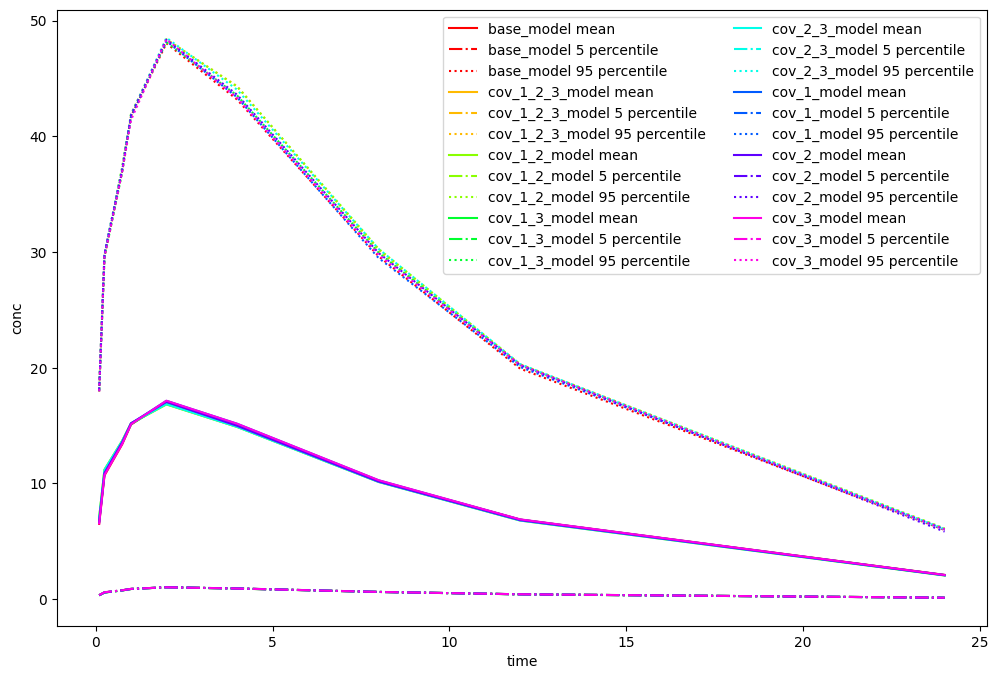

In [8]:
total_df = pd.DataFrame()

model_name = str
pred_dict: Dict[model_name, np.array]= {}
seeds = sorted([entry for entry in logs_dir.iterdir() if entry.is_dir()])
for seed in tqdm(seeds, desc='seed', leave=False):
    seed_name = seed.name
    models = sorted(list(seed.iterdir()))
    for model in models:
        pred_npy_path = model/Path('pred.npy')
        pred = pred_dict.get(model.name, None)
        if pred is None :
            pred_dict[model.name] = np.load(pred_npy_path)
        else :
            pred_dict[model.name] = np.concatenate([pred, np.load(pred_npy_path)])

from matplotlib.colors import hsv_to_rgb

fig, axs = plt.subplots(figsize=(12,8))
time = np.array([0.1,0.25,0.75,1.,2.,4.,8.,12.,24.])
model_names = ['base_model', 'cov_1_2_3_model', 'cov_1_2_model', 'cov_1_3_model', 'cov_2_3_model', 'cov_1_model', 'cov_2_model', 'cov_3_model']
ax = axs
for model_name, hue in zip(model_names, np.linspace(0,0.85,len(model_names))):
    preds = pred_dict[model_name]
    ax : Axes = ax
    # ax.set_ylim(0,40)
    preds = np.squeeze(preds, -1)
    preds = np.exp(preds)
    means = preds.mean(0)
    percentile_5, percentile_95 = np.percentile(preds, [5,95], axis=0)
    # for pred in preds :
    ax.set_xlabel('time')
    ax.set_ylabel('conc')
    color = hsv_to_rgb([hue,1,1])
    ax.plot(time, means, label=f'{model_name} mean', color=color)
    ax.plot(time, percentile_5, label=f'{model_name} 5 percentile', color=color, linestyle='-.')
    ax.plot(time, percentile_95, label=f'{model_name} 95 percentile', color=color, linestyle=':')
    # ax.set_yscale('log')
    
    # ax.scatter(np.repeat(time, preds.shape[0]).flatten(), np.exp(preds).flatten(), vmin=0, vmax=10)
ax.legend(ncol=2)
# ax.legend(['base_model', 'cov_1_2_3_model', 'cov_1_2_model', 'cov_1_3_model', 'cov_2_3_model', 'cov_1_model', 'cov_2_model', 'cov_3_model'], )

seed:   0%|          | 0/50 [00:00<?, ?it/s]

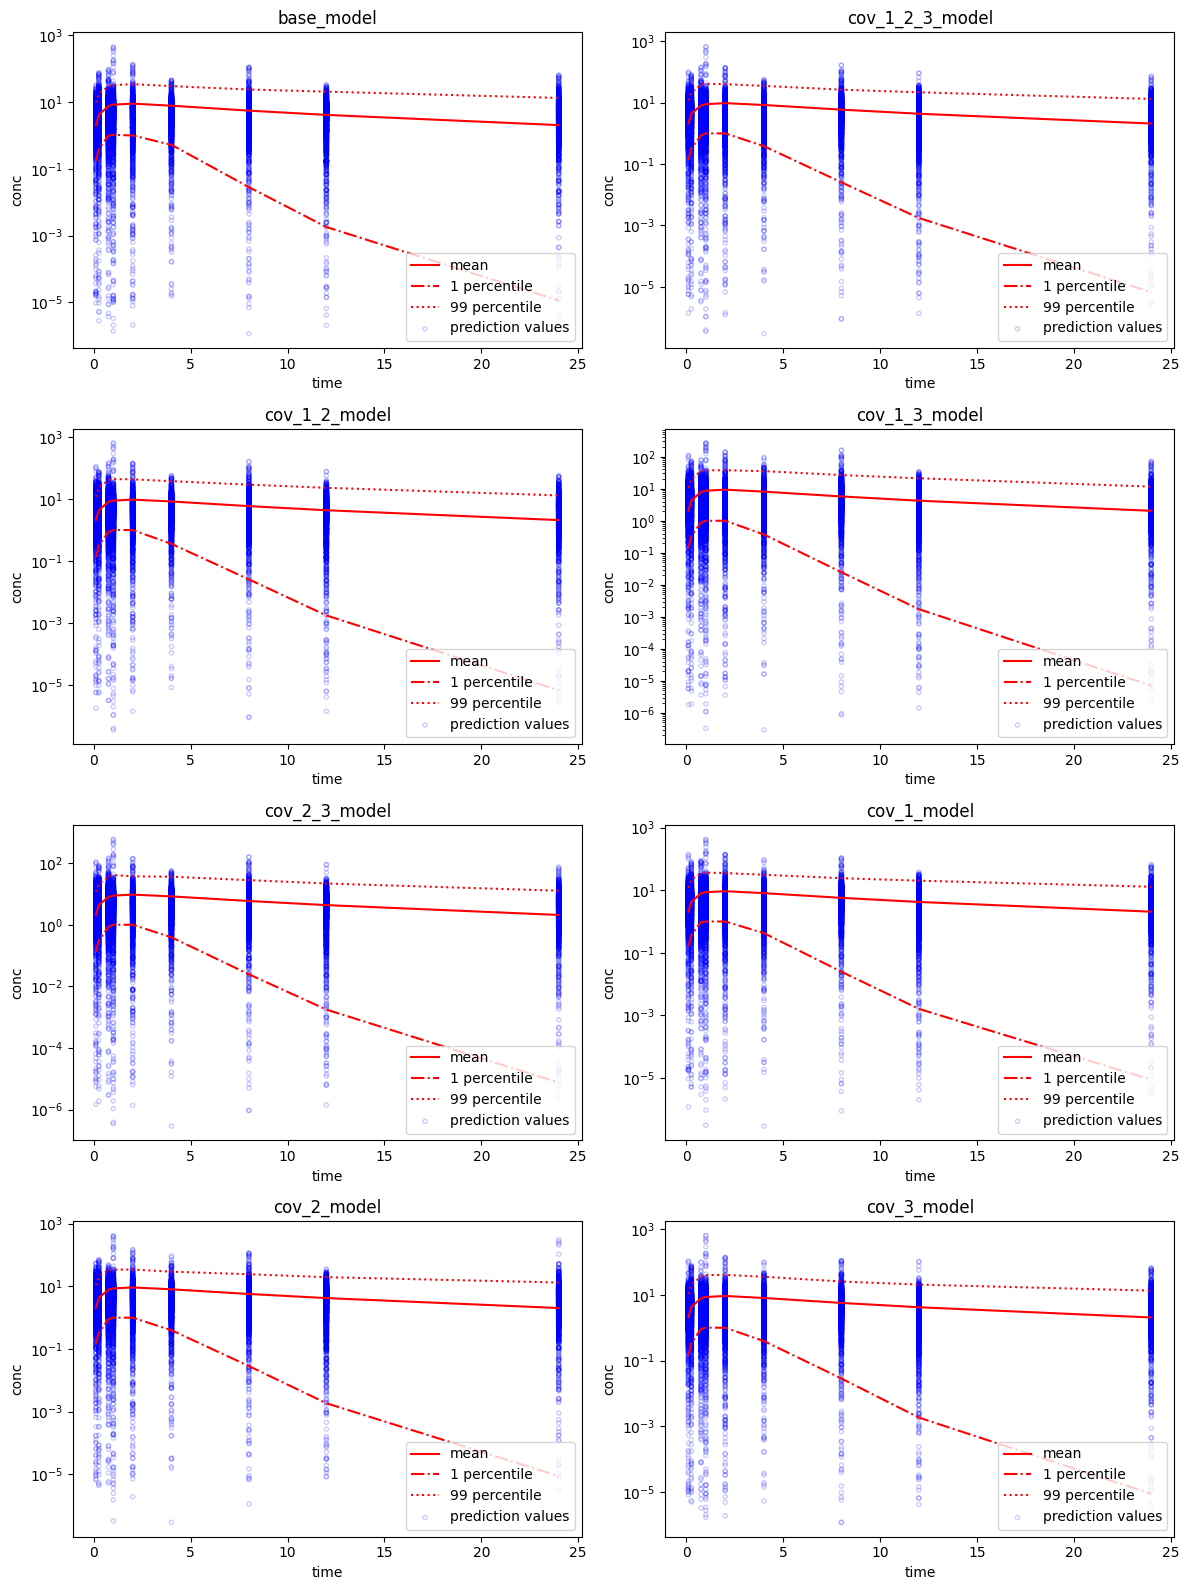

In [9]:
logs_dir = Path("../lightning_logs/theo_cov_013019")

# result_csv_path = Path(f"results_{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.csv")
results_dir = Path(f"results/")
results_dir.mkdir(parents=True, exist_ok=True)

total_df = pd.DataFrame()

model_name = str
pred_dict: Dict[model_name, np.array]= {}
seeds = sorted([entry for entry in logs_dir.iterdir() if entry.is_dir()])
for seed in tqdm(seeds, desc='seed', leave=False):
    seed_name = seed.name
    models = sorted(list(seed.iterdir()))
    for model in models:
        pred_npy_path = model/Path('pred.npy')
        pred = pred_dict.get(model.name, None)
        if pred is None :
            pred_dict[model.name] = np.load(pred_npy_path)
        else :
            pred_dict[model.name] = np.concatenate([pred, np.load(pred_npy_path)])

from matplotlib.colors import hsv_to_rgb

fig, axs = plt.subplots(4,2, figsize=(12,16))
axs : Axes = axs
time = np.array([0.1,0.25,0.75,1.,2.,4.,8.,12.,24.])
model_names = ['base_model', 'cov_1_2_3_model', 'cov_1_2_model', 'cov_1_3_model', 'cov_2_3_model', 'cov_1_model', 'cov_2_model', 'cov_3_model']
for ax, model_name, hue in zip(axs.flatten(), model_names, np.linspace(0,0.85,len(model_names))):
    preds = pred_dict[model_name]
    ax : Axes = ax
    # ax.set_ylim(0,40)
    preds = np.squeeze(preds, -1)
    preds = np.exp(preds)
    means = preds.mean(0)
    percentile_1, percentile_5, percentile_95, percentile_99 = np.percentile(preds, [1, 5,95, 99], axis=0)
    # for pred in preds :
    ax.set_xlabel('time')
    ax.set_ylabel('conc')
    color = 'r'
    ax.set_title(model_name)
    ax.plot(time, means, label=f'mean', color=color)
    ax.plot(time, percentile_1, label=f'1 percentile', color=color, linestyle='-.')
    # ax.plot(time, percentile_5, label=f'{model_name} 5 percentile', alpha=0.8, color=color, linestyle='-.')
    # ax.plot(time, percentile_95, label=f'{model_name} 95 percentile', alpha=0.8, color=color, linestyle=':')
    ax.plot(time, percentile_99, label=f'99 percentile', color=color, linestyle=':')
    ax.scatter(time.repeat(preds.shape[0]), preds, label=f'prediction values', alpha=0.2, marker='.', facecolors='none', edgecolors='b')
    ax.set_yscale('log')
    
    # ax.scatter(np.repeat(time, preds.shape[0]).flatten(), np.exp(preds).flatten(), vmin=0, vmax=10)
    ax.legend()
# ax.legend(['base_model', 'cov_1_2_3_model', 'cov_1_2_model', 'cov_1_3_model', 'cov_2_3_model', 'cov_1_model', 'cov_2_model', 'cov_3_model'], )
fig.tight_layout()